For this notebook, the comparison is between using two different algorithms to generates points within a unit disk (2D) or unit sphere (3D).  The first algorithm is a rejection based method, while the other is an analytical solution.  All code was compiled with the `Release` flag turned on, and with using the real trigonometric functions (by default approximations are used).

In [1]:
from dataclasses import dataclass
import statistics
from collections import OrderedDict
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sheet_file_name ='psrt_rejection_vs_analytical_test_suite_results.xlsx'
excel_file = load_workbook(sheet_file_name)

# How many rows down does the actual data (we're interested in) start from?
data_start_offset = 7

num_test_cases = excel_file.worksheets[0].max_row - data_start_offset
num_test_cases_per_scene = 50  # TODO would like a "smarter" way of geting this number, not hard coding it...

In [2]:
@dataclass
class TestCase:
    id_num: int
    scene_id: str

    # runtimes, measured in milliseconds 
    baseline_runtime_ms: int
    venture_runtime_ms: int

    def venture_slower_by_ms(self) -> int:
        '''How much slower using the venture was. Could return a negative, meaning the venture was faster'''
        return self.venture_runtime_ms - self.baseline_runtime_ms

    def venture_faster_by_ms(self) -> int:
        '''How much was the venture faster by, may return a negative meaning it was slower'''
        return -self.venture_slower_by_ms()

    def percent_venture_slower_by(self) -> float:
        '''Percent-wise how much slower the venture was'''
        return (self.venture_runtime_ms - self.baseline_runtime_ms) / self.baseline_runtime_ms

    def percent_venture_faster_by(self) -> float:
        '''Percent-wise how much faster the venture was'''
        return (self.baseline_runtime_ms - self.venture_runtime_ms) / self.baseline_runtime_ms

In [3]:
def _ms_to_time_str(milliseconds: int) -> str:
    total_seconds = milliseconds // 1000
    hours = total_seconds // (60 * 60)
    s = total_seconds % (60 * 60)
    minutes = s // 60
    seconds = s % 60
    
    return f'{hours}h {minutes}m {seconds}s'
    

@dataclass
class TestSuite:
    cpu: str
    os: str
    compiler: str

    # Measured in milliseconds
    baseline_total_runtime_ms: int
    venture_total_runtime_ms: int

    test_cases: list[TestCase]

    def baseline_total_runtime_str(self) -> str:
        return _ms_to_time_str(self.baseline_total_runtime_ms)
        
    def venture_total_runtime_str(self) -> str:
        return _ms_to_time_str(self.venture_total_runtime_ms)

    def matplotlib_config_name(self) -> str:
        '''For displaying the configuration in matplotlib renderings'''
        # This makes the compiler name easier to read
        if (' (' in self.compiler):
            self.compiler = self.compiler.replace(' (', '\n(')
        
        return '\n'.join([self.cpu, self.os, self.compiler])

    def pandas_column_header(self) -> str:
        '''For displaying the configuration in a header in a table'''
        return self.matplotlib_config_name().replace('\n', '<br>')

    def overall_was_venture_more_performant(self) -> bool:
        return (self.venture_total_runtime_ms < self.baseline_total_runtime_ms)

    def overall_how_much_faster_was_venture(self) -> float:
        # Assumes that venture was always faster
        diff = self.baseline_total_runtime_ms - self.venture_total_runtime_ms
        return (diff / self.baseline_total_runtime_ms)

    def _find_cases_where(self, comparison_func) -> list[TestCase]:
        '''Internal function to compare the venture vs. non-used-venture test case,
        and collect them into a list.  comparision_func takes one arguement (a test
        case) and should return a bool'''
        return list(filter(lambda x: comparison_func(x), self.test_cases))
        
    def find_cases_where_venture_was_slower(self) -> list[TestCase]:
        '''Retuns a list of test cases where the usage of the venture was slower'''
        def _venture_slower(test_case):
            return (test_case.venture_runtime_ms >= test_case.baseline_runtime_ms)

        return self._find_cases_where(_venture_slower)

    def find_cases_where_venture_was_faster(self) -> list[TestCase]:
        '''Returns a list of test cases where the usage of the venture was faster'''
        def _venture_faster(test_case):
            return (test_case.venture_runtime_ms < test_case.baseline_runtime_ms)

        return self._find_cases_where(_venture_faster)        

    def find_cases_where_venture_was_slower_by_at_least(self, by_percent: float) -> list[TestCase]:
        '''Find where the test case was slower with the venture turned on;  By a certain percentage'''
        all_where_slower = self.find_cases_where_venture_was_slower()
        return list(filter(lambda x: (x.percent_venture_slower_by() >= by_percent), all_where_slower))
        
    def find_cases_where_venture_was_faster_by_at_least(self, by_percent: float) -> list[TestCase]:
        '''Find where the test case was faster with the venture turned on;  By a certain percentage'''
        all_where_faster = self.find_cases_where_venture_was_faster()
        return list(filter(lambda x: (x.percent_venture_faster_by() >= by_percent), all_where_faster))

In [4]:
results = []
num_configurations = 0

def pairwise(iterable):
    a = iter(iterable)
    return zip(a, a)

# Parse the data into something we can use/analyze
for (baseline, venture) in pairwise(excel_file.worksheets):
    num_configurations += 1
    
    # Extract out the summary data
    baseline_summary_data = baseline['A1:B5']
    venture_summary_data = venture['A1:B5']

    # Grab the configuration (and results of each individual test)
    data_start_offset = 8
    range_to_grab = f'A{data_start_offset}:I{data_start_offset + num_test_cases - 1}'
    baseline_test_data = baseline[range_to_grab]
    venture_test_data = venture[range_to_grab]
    
    # Get all the data from each test case
    test_cases = []
    for r in range(0, num_test_cases):
        test_cases.append(TestCase(
            int(baseline_test_data[r][0].value),    # id no.
            baseline_test_data[r][1].value,         # scene name

            # Render time
            int(baseline_test_data[r][8].value),
            int(venture_test_data[r][8].value)
        ))

    # Put them into the suite results
    results.append(TestSuite(
        baseline_summary_data[0][1].value,
        baseline_summary_data[1][1].value,
        baseline_summary_data[2][1].value,
        
        int(baseline_summary_data[4][1].value),
        int(venture_summary_data[4][1].value),
        test_cases
    ))

In [5]:
configs = [x.pandas_column_header() for x in results]

yes_str = '<div style="background-color: #BFFEBC">Yes</div>'
no_str = '<div style="background-color: #FFCFCF">No</div>'

# Make a table showing the overall performance
data = [
    [(yes_str if x.overall_was_venture_more_performant() else no_str) for x in results],
    [('{:.2%}'.format(x.overall_how_much_faster_was_venture())) for x in results],
    [x.baseline_total_runtime_str() for x in results],
    [x.venture_total_runtime_str() for x in results],
]
row_labels = [
    'Was the analytical method faster?',
    'By how much',
    'Total run time using rejection sampling',
    'Total run time using the analytical method',
]

overall_table = pd.DataFrame(columns=configs, data=data)
overall_table.style\
  .set_caption(f'<h1>Overall Performance</h1>')\
  .relabel_index(row_labels, axis=0)
#  .set_table_styles([{'selector': 'td', 'props': [('margin', '2em')]}])\

,i7-10750HUbuntu 24.04.1GCC 14.2.0,i7-10750HUbuntu 24.04.1clang 18.1.3,i7-10750HWindows 11 HomeGCC 14.1.0(w64devkit),i7-10750HWindows 11 HomeMSVC 2022(19.39.33523),Ryzen 9 6900HXUbuntu 24.04.1GCC 14.2.0,Ryzen 9 6900HXUbuntu 24.04.1clang 18.1.3,Ryzen 9 6900HXWindows 11 HomeGCC 14.1.0(w64devkit),Ryzen 9 6900HXWindows 11 HomeMSVC 2022(19.38.33135),M1macOS 14.4.1GCC 13.2.0(homebrew),M1macOS 14.4.1clang 15.0.0
Was the analytical method faster?,No,Yes,No,No,No,Yes,Yes,No,No,No
By how much,-3.24%,1.55%,-4.35%,-0.75%,-1.06%,5.39%,2.16%,-3.69%,-4.06%,-1.53%
Total run time using rejection sampling,14h 47m 54s,20h 39m 10s,17h 42m 30s,22h 17m 3s,14h 43m 49s,22h 54m 50s,18h 17m 25s,19h 59m 38s,10h 34m 29s,9h 54m 55s
Total run time using the analytical method,15h 16m 38s,20h 19m 57s,18h 28m 41s,22h 27m 3s,14h 53m 12s,21h 40m 45s,17h 53m 44s,20h 43m 50s,11h 0m 13s,10h 4m 3s


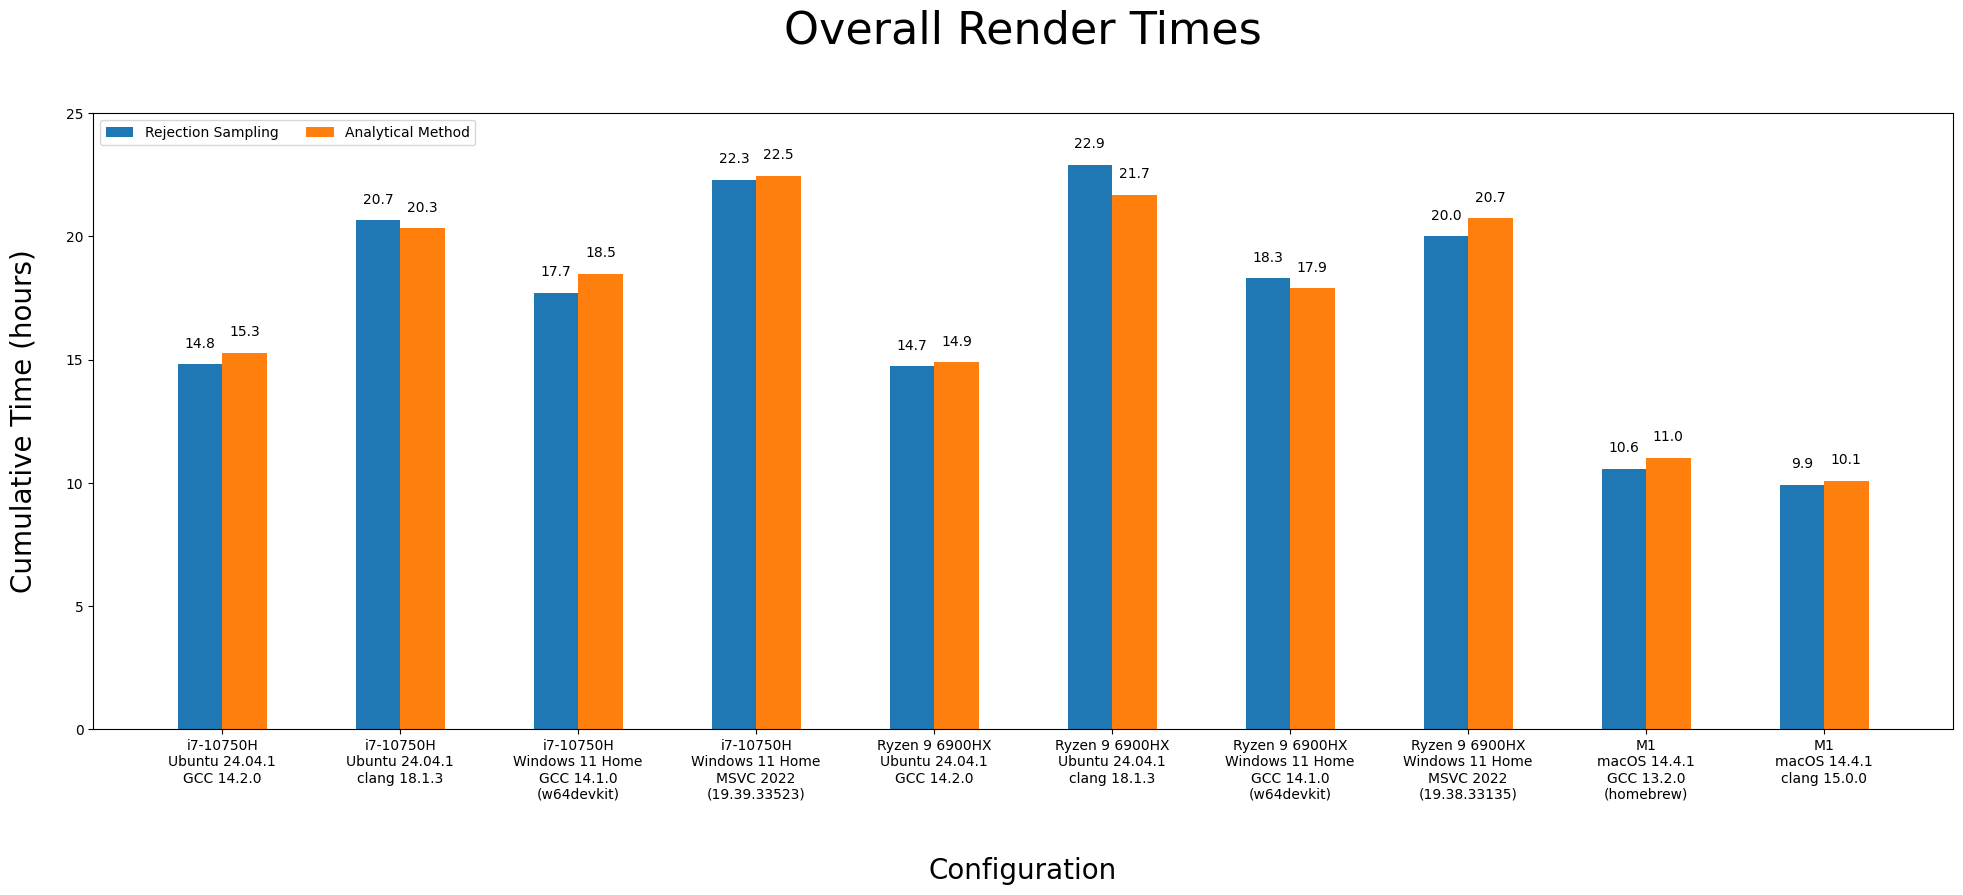

In [6]:
# Bar chart visualization of the above table

def ms_to_s(x: int) -> float:
    return x / 1000

def s_to_hr(x: float) -> float:
    return x / 60 / 60

def ms_to_hr(x: int) -> float:
    return s_to_hr(ms_to_s(x))

# Convert the overall suite runtime from nanoseconds to hours
baseline_runtimes = [ms_to_hr(x.baseline_total_runtime_ms) for x in results]
venture_runtimes = [ms_to_hr(x.venture_total_runtime_ms) for x in results]

configs = [x.matplotlib_config_name() for x in results]
runtimes = {
    'Rejection Sampling': baseline_runtimes,
    'Analytical Method': venture_runtimes,
}

# Create the bar chart
x = np.arange(len(configs))
bar_width = 0.25
multiplier = 0.5

plt.rcParams['figure.figsize'] = [24, 8]
fig, ax = plt.subplots()

for (config_name, runtime_hrs) in runtimes.items():
    offset = bar_width * multiplier
    rects = ax.bar(x + offset, runtime_hrs, bar_width, label=config_name)
    ax.bar_label(rects, padding=10, fmt='%.1f')
    multiplier += 1

ax.set_title('Overall Render Times', fontsize=32, pad=50)
ax.set_ylabel('Cumulative Time (hours)', fontsize=20, labelpad=20)
ax.set_xlabel('Configuration', fontsize=20, labelpad=40)
ax.set_xticks(x + bar_width, configs)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 25)

plt.show()

(Lower is better)

### Reminder: This is not supposed to be a compiler comparison, but a comparison of "feature-off" vs. "feature-on"

In [7]:
def make_table_showing_performance_percentages(slower_or_faster: str, lower: int = 1, upper: int = 5):
    '''This function will generate a table that will show for each configuration, how
    many tests (percentage) wise are faster or slower with the venture on or off.  It's
    a little confusing TBH.  First arugument to this function should be `slower` or `faster`;
    the second and third arguments are the range to show (inclusive).'''

    # Decide on the colour, and function to use to grab tests
    if slower_or_faster == 'slower':
        cmap = 'YlOrRd'
        f = TestSuite.find_cases_where_venture_was_slower_by_at_least
    elif slower_or_faster == 'faster':
        cmap = 'Greens'
        f = TestSuite.find_cases_where_venture_was_faster_by_at_least

    # Percentages to test
    perf_percentages = [(x / 100) for x in range(lower, (upper + 1))]
    
    row_labels = []
    data = []
    for pp in perf_percentages:
        row_labels.append(f'≥ {pp:.0%} {slower_or_faster}')
        row_data = []

        # Figure out the percentage of test cases, at or above the performance level
        for r in results:
            cases = f(r, pp)
            ratio = len(cases) / num_test_cases
            row_data.append(ratio)
    
        data.append(row_data)
    
    def _make_pretty(styler):
        styler.set_caption(f'<h2>Percent of test cases where the analytical method was {slower_or_faster}</h2><h4>(out of {num_test_cases} test cases)</h4><br><br>')
        styler.relabel_index(row_labels, axis=0)
        styler.format('{:.1%}')
        styler.background_gradient(axis=None, cmap=cmap, vmin=0, vmax=1)
        return styler
    
    # Display the data
    table = pd.DataFrame(columns=configs, data=data)
    return (table, _make_pretty)

In [8]:
# Show the faster cases
(table, make_pretty) = make_table_showing_performance_percentages('faster', 1, 10)
table.style.pipe(make_pretty)

,i7-10750H Ubuntu 24.04.1 GCC 14.2.0,i7-10750H Ubuntu 24.04.1 clang 18.1.3,i7-10750H Windows 11 Home GCC 14.1.0 (w64devkit),i7-10750H Windows 11 Home MSVC 2022 (19.39.33523),Ryzen 9 6900HX Ubuntu 24.04.1 GCC 14.2.0,Ryzen 9 6900HX Ubuntu 24.04.1 clang 18.1.3,Ryzen 9 6900HX Windows 11 Home GCC 14.1.0 (w64devkit),Ryzen 9 6900HX Windows 11 Home MSVC 2022 (19.38.33135),M1 macOS 14.4.1 GCC 13.2.0 (homebrew),M1 macOS 14.4.1 clang 15.0.0
≥ 1% faster,4.1%,64.8%,3.1%,11.8%,6.8%,85.2%,11.6%,10.8%,1.4%,0.9%
≥ 2% faster,2.2%,43.1%,1.6%,6.7%,3.8%,78.0%,10.6%,8.0%,0.9%,0.7%
≥ 3% faster,1.3%,26.5%,0.7%,3.6%,2.1%,65.0%,9.2%,5.1%,0.7%,0.5%
≥ 4% faster,1.1%,16.1%,0.4%,2.4%,1.1%,52.8%,7.6%,2.9%,0.4%,0.4%
≥ 5% faster,0.6%,8.6%,0.4%,1.6%,0.8%,42.5%,6.5%,2.0%,0.1%,0.2%
≥ 6% faster,0.4%,4.3%,0.2%,0.9%,0.7%,36.6%,5.7%,1.8%,0.1%,0.2%
≥ 7% faster,0.2%,2.1%,0.2%,0.7%,0.4%,33.1%,4.9%,1.7%,0.1%,0.2%
≥ 8% faster,0.1%,0.9%,0.1%,0.4%,0.3%,30.6%,4.5%,1.5%,0.1%,0.2%
≥ 9% faster,0.1%,0.5%,0.1%,0.4%,0.3%,27.9%,4.0%,1.5%,0.1%,0.1%
≥ 10% faster,0.0%,0.2%,0.1%,0.3%,0.2%,25.3%,3.9%,1.4%,0.0%,0.1%


In [9]:
# Show the slower cases
(table, make_pretty) = make_table_showing_performance_percentages('slower', 1, 10)
table.style.pipe(make_pretty)

,i7-10750H Ubuntu 24.04.1 GCC 14.2.0,i7-10750H Ubuntu 24.04.1 clang 18.1.3,i7-10750H Windows 11 Home GCC 14.1.0 (w64devkit),i7-10750H Windows 11 Home MSVC 2022 (19.39.33523),Ryzen 9 6900HX Ubuntu 24.04.1 GCC 14.2.0,Ryzen 9 6900HX Ubuntu 24.04.1 clang 18.1.3,Ryzen 9 6900HX Windows 11 Home GCC 14.1.0 (w64devkit),Ryzen 9 6900HX Windows 11 Home MSVC 2022 (19.38.33135),M1 macOS 14.4.1 GCC 13.2.0 (homebrew),M1 macOS 14.4.1 clang 15.0.0
≥ 1% slower,90.5%,10.2%,93.4%,74.5%,83.2%,7.6%,85.3%,82.5%,92.4%,83.0%
≥ 2% slower,85.2%,4.9%,90.3%,66.0%,77.0%,6.6%,82.2%,78.8%,87.9%,71.9%
≥ 3% slower,79.7%,2.2%,85.5%,55.9%,69.2%,5.5%,77.8%,72.5%,79.9%,57.2%
≥ 4% slower,73.1%,0.9%,81.2%,46.3%,58.8%,4.7%,73.0%,65.0%,71.6%,45.0%
≥ 5% slower,66.8%,0.2%,76.6%,37.2%,49.5%,3.7%,67.7%,57.0%,64.5%,35.1%
≥ 6% slower,59.3%,0.2%,71.8%,29.7%,40.6%,2.4%,61.3%,47.2%,55.5%,26.7%
≥ 7% slower,52.6%,0.1%,67.4%,22.4%,31.6%,1.8%,53.8%,37.5%,49.4%,19.9%
≥ 8% slower,46.6%,0.1%,63.3%,16.4%,24.5%,1.1%,45.1%,29.2%,43.8%,12.7%
≥ 9% slower,39.2%,0.1%,59.8%,12.1%,18.2%,0.8%,36.7%,24.1%,37.3%,8.9%
≥ 10% slower,33.2%,0.0%,55.4%,8.9%,13.4%,0.4%,29.8%,20.0%,31.3%,6.6%


In [10]:
# Not a fan of doing this, but it extracts the scene Id's for us to display in the table
_scene_ids = []

def make_table_for_stat_measurement(function, table_title: str, cmap: str='RdBu', vmin=-0.1, vmax=0.1):
    '''This function will let you make a table that shows the summary for a "satistical measurement" function.

    For example, if you want to see the average performance increase/decrease of "feature-on" vs. "feature off", you would pass in
    `statistics.mean` to `function`.   If you wanted to see the Median, use `statistics.median`.  Note that this
    funtion returns a tuple of the pandas.DataFrame and an styling function to call on the data frame.
    '''
    
    global _scene_ids
    global num_test_cases_per_scene
    global num_test_cases

    data = {}
    for (config_index, config_name) in enumerate(configs):
        all_scenes = OrderedDict()
        suite = results[config_index]

        # Organize each scene to see how much percent faster it is
        for tc in suite.test_cases:
            sid = tc.scene_id
            p_faster = tc.percent_venture_faster_by()
            
            if sid in all_scenes:
                all_scenes[sid].append(p_faster)  # Add value
            else:
                all_scenes[sid] = [p_faster]      # New list

        scene_ids = []
        computed = []
        for (scene_id, measurements) in all_scenes.items():
            scene_ids.append(scene_id)
            computed.append(function(measurements))
            
            
        data[config_name] = computed
    
    def _make_pretty(styler):
        styler.format('{:.1%}')
        styler.set_table_styles([
            {'selector': '.row_heading', 'props': [('text-align', 'left')]}
        ])
        styler.background_gradient(axis=None, cmap=cmap, vmin=vmin, vmax=vmax)
        styler.set_caption(table_title)
        styler.relabel_index(_scene_ids, axis=0)
        return styler

    # Set globals (always will be the same)
    _scene_ids = scene_ids
    num_test_cases_per_scene = num_test_cases / len(_scene_ids)

    # Return data
    table = pd.DataFrame(data=data)
    return (table, _make_pretty)

In [11]:
(table, make_pretty) = make_table_for_stat_measurement(
    statistics.mean,
    f'<h2>Average of how much faster/slower the analytical method was (when used)</h2><h4>(Each scene being tested at least {int(num_test_cases_per_scene)} times)</h4><br><br>'
)
table.style.pipe(make_pretty)

,i7-10750H Ubuntu 24.04.1 GCC 14.2.0,i7-10750H Ubuntu 24.04.1 clang 18.1.3,i7-10750H Windows 11 Home GCC 14.1.0 (w64devkit),i7-10750H Windows 11 Home MSVC 2022 (19.39.33523),Ryzen 9 6900HX Ubuntu 24.04.1 GCC 14.2.0,Ryzen 9 6900HX Ubuntu 24.04.1 clang 18.1.3,Ryzen 9 6900HX Windows 11 Home GCC 14.1.0 (w64devkit),Ryzen 9 6900HX Windows 11 Home MSVC 2022 (19.38.33135),M1 macOS 14.4.1 GCC 13.2.0 (homebrew),M1 macOS 14.4.1 clang 15.0.0
book1::surface_normal_sphere,-11.5%,1.6%,-16.3%,-8.5%,-4.6%,2.1%,-11.6%,-7.9%,-12.4%,-7.1%
book1::grey_sphere,-12.4%,1.5%,-21.0%,-6.8%,-4.2%,2.7%,-11.2%,-8.5%,-12.5%,-7.9%
book1::shiny_metal_sphere,-16.7%,5.6%,-28.5%,-10.7%,-8.6%,17.4%,-14.1%,-11.0%,-16.9%,-9.4%
book1::fuzzy_metal_sphere,-15.8%,4.7%,-24.5%,-10.9%,-8.5%,15.8%,-12.9%,-11.3%,-16.8%,-10.8%
book1::two_glass_one_metal_spheres,-10.4%,3.1%,-17.4%,-6.3%,-4.0%,8.4%,-11.1%,-5.7%,-11.7%,-6.7%
book1::glass_blue_metal_spheres,-12.3%,2.6%,-19.6%,-7.3%,-4.3%,11.0%,-10.0%,-6.7%,-11.9%,-7.7%
book1::red_blue_spheres,-13.5%,0.2%,-21.6%,-8.6%,-6.5%,3.2%,-12.8%,-9.0%,-15.3%,-8.6%
book1::hollow_glass_blue_metal_spheres,-10.8%,1.8%,-16.6%,-6.4%,-4.1%,10.5%,-3.7%,-5.6%,-10.0%,-6.1%
book1::hollow_glass_blue_metal_spheres::far_view,-12.2%,1.2%,-17.5%,-6.0%,-5.9%,4.5%,-6.9%,-7.2%,-12.3%,-6.9%
book1::hollow_glass_blue_metal_spheres::close_view,-8.4%,2.3%,-12.7%,-4.4%,-1.9%,8.1%,-3.4%,-4.9%,-8.2%,-5.2%


In [12]:
(table, make_pretty) = make_table_for_stat_measurement(
    statistics.median,
    f'<h2>Median of how much faster/slower the analytical method was used (when used)</h2><h4>(Each scene being tested at least {int(num_test_cases_per_scene)} times)</h4><br><br>'
)
table.style.pipe(make_pretty)

,i7-10750H Ubuntu 24.04.1 GCC 14.2.0,i7-10750H Ubuntu 24.04.1 clang 18.1.3,i7-10750H Windows 11 Home GCC 14.1.0 (w64devkit),i7-10750H Windows 11 Home MSVC 2022 (19.39.33523),Ryzen 9 6900HX Ubuntu 24.04.1 GCC 14.2.0,Ryzen 9 6900HX Ubuntu 24.04.1 clang 18.1.3,Ryzen 9 6900HX Windows 11 Home GCC 14.1.0 (w64devkit),Ryzen 9 6900HX Windows 11 Home MSVC 2022 (19.38.33135),M1 macOS 14.4.1 GCC 13.2.0 (homebrew),M1 macOS 14.4.1 clang 15.0.0
book1::surface_normal_sphere,-11.3%,1.5%,-16.3%,-8.1%,-3.3%,2.2%,-11.6%,-7.6%,-12.3%,-7.3%
book1::grey_sphere,-12.2%,1.6%,-17.9%,-6.5%,-5.0%,2.9%,-11.6%,-8.0%,-12.6%,-7.7%
book1::shiny_metal_sphere,-16.5%,6.0%,-26.9%,-10.9%,-8.3%,17.7%,-13.4%,-10.4%,-17.6%,-11.3%
book1::fuzzy_metal_sphere,-15.2%,4.4%,-25.0%,-10.4%,-8.5%,17.1%,-12.5%,-10.7%,-16.7%,-10.4%
book1::two_glass_one_metal_spheres,-10.0%,2.7%,-16.2%,-6.2%,-3.4%,7.9%,-10.0%,-6.0%,-11.3%,-6.3%
book1::glass_blue_metal_spheres,-12.1%,2.7%,-18.9%,-7.1%,-4.3%,11.1%,-9.8%,-6.7%,-12.3%,-7.4%
book1::red_blue_spheres,-13.3%,0.6%,-21.8%,-9.1%,-6.4%,3.1%,-13.0%,-8.8%,-15.3%,-8.9%
book1::hollow_glass_blue_metal_spheres,-11.1%,1.7%,-16.2%,-6.4%,-3.8%,11.2%,-3.8%,-6.3%,-10.1%,-6.2%
book1::hollow_glass_blue_metal_spheres::far_view,-12.5%,1.4%,-17.3%,-6.3%,-5.1%,4.8%,-7.0%,-7.0%,-13.0%,-7.0%
book1::hollow_glass_blue_metal_spheres::close_view,-8.3%,1.9%,-12.7%,-4.4%,-1.7%,8.4%,-4.0%,-5.7%,-8.3%,-5.2%


In [13]:
(table, make_pretty) = make_table_for_stat_measurement(
    statistics.variance,
f'<h2>Variance of data measurements with the analytical method (was used).</h2><h4>(Each scene being tested at least {int(num_test_cases_per_scene)} times), lower is better</h4><br><br>',
    cmap='Reds',
    vmin=0.01,
    vmax=0.1
)
table.style.pipe(make_pretty)

,i7-10750H Ubuntu 24.04.1 GCC 14.2.0,i7-10750H Ubuntu 24.04.1 clang 18.1.3,i7-10750H Windows 11 Home GCC 14.1.0 (w64devkit),i7-10750H Windows 11 Home MSVC 2022 (19.39.33523),Ryzen 9 6900HX Ubuntu 24.04.1 GCC 14.2.0,Ryzen 9 6900HX Ubuntu 24.04.1 clang 18.1.3,Ryzen 9 6900HX Windows 11 Home GCC 14.1.0 (w64devkit),Ryzen 9 6900HX Windows 11 Home MSVC 2022 (19.38.33135),M1 macOS 14.4.1 GCC 13.2.0 (homebrew),M1 macOS 14.4.1 clang 15.0.0
book1::surface_normal_sphere,0.1%,0.0%,0.2%,0.1%,0.2%,0.0%,0.1%,0.1%,0.1%,0.1%
book1::grey_sphere,0.1%,0.0%,0.8%,0.1%,0.1%,0.0%,0.1%,0.3%,0.1%,0.1%
book1::shiny_metal_sphere,0.2%,0.1%,0.7%,0.2%,0.2%,0.4%,0.3%,0.2%,0.2%,0.6%
book1::fuzzy_metal_sphere,0.2%,0.0%,0.6%,0.2%,0.2%,0.4%,0.3%,0.2%,0.2%,0.1%
book1::two_glass_one_metal_spheres,0.1%,0.0%,0.3%,0.1%,0.1%,0.2%,0.1%,0.1%,0.1%,0.0%
book1::glass_blue_metal_spheres,0.1%,0.0%,0.2%,0.1%,0.2%,0.1%,0.1%,0.1%,0.1%,0.1%
book1::red_blue_spheres,0.0%,0.0%,0.1%,0.1%,0.1%,0.0%,0.1%,0.1%,0.1%,0.1%
book1::hollow_glass_blue_metal_spheres,0.0%,0.0%,0.1%,0.0%,0.1%,0.2%,0.2%,0.1%,0.0%,0.0%
book1::hollow_glass_blue_metal_spheres::far_view,0.0%,0.0%,0.1%,0.0%,0.1%,0.0%,0.0%,0.0%,0.1%,0.1%
book1::hollow_glass_blue_metal_spheres::close_view,0.0%,0.0%,0.1%,0.1%,0.1%,0.1%,0.1%,0.0%,0.0%,0.0%
